In [1]:
import m2aia as m2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from download_helper import DownloadMTBLS2639
file_names = DownloadMTBLS2639(selection=[2])

def showimg(image, cmap=None, title=None):
    sns.set_theme(style="ticks")
    fig = plt.figure(figsize = (10,10)) # create a 5 x 5 figure 
    ax = fig.add_subplot(111)
    ax.tick_params(
        which='both',
        bottom=False,
        left=False,
        labelleft=False,
        labelbottom=False)
    x = [10,60]
    y = [10,10]

    spacing = I.GetSpacing()
    ax.plot(x, y, color="white", linewidth=3)
    ax.text(x[0], y[0]+7, f"{int(spacing[0]*(x[1]-x[0])* 1000)} μm", color="white",size=14)
    if title:
        ax.text(x[0], y[0]-3, title, color="white", size=14)
    ax.imshow(image, interpolation='none', cmap=cmap)

    return fig, ax 

In [2]:
# Set the parameters
I = m2.ImzMLReader(str(file_names[0]))
#I.SetNormalization(m2.m2NormalizationTIC)
I.SetSmoothing(m2.m2SmoothingGaussian,12)
I.SetBaselineCorrection(m2.m2BaselineCorrectionTopHat)
I.Execute()

(<Figure size 1000x1000 with 1 Axes>, <AxesSubplot: >)

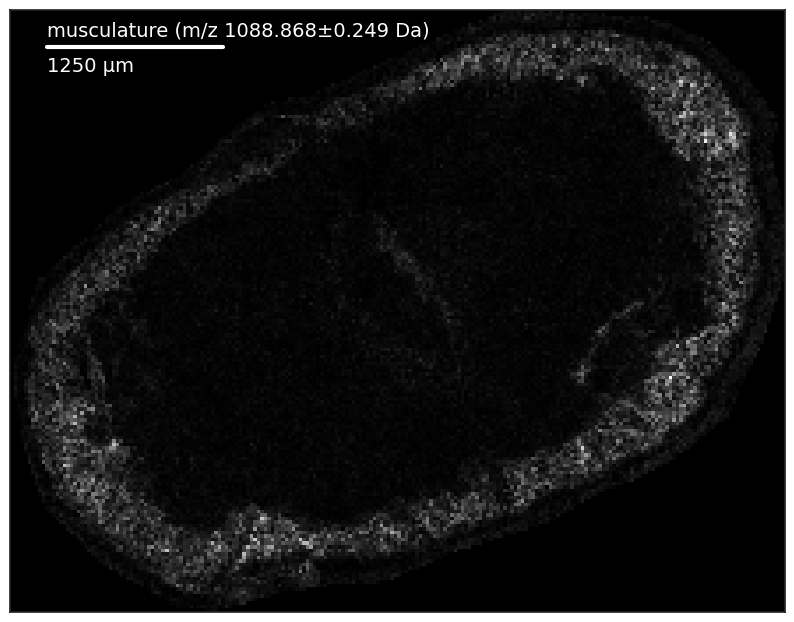

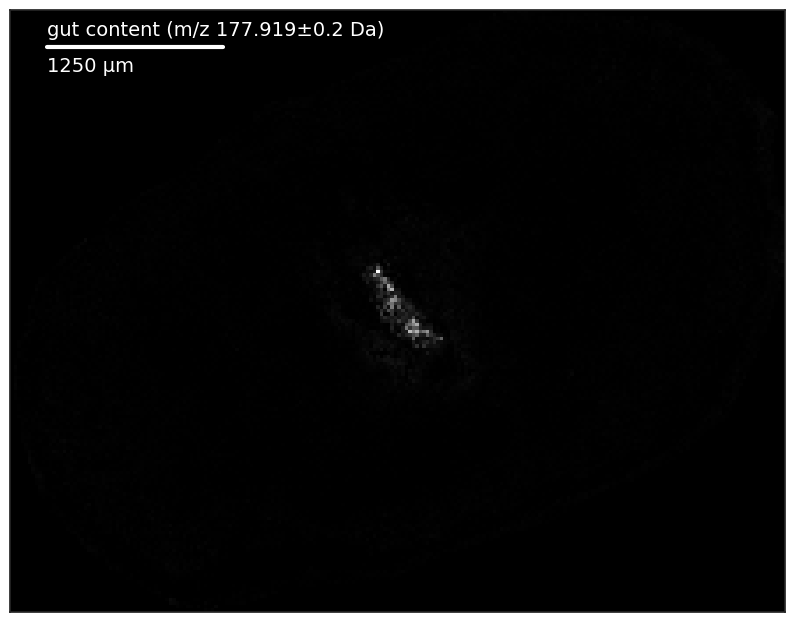

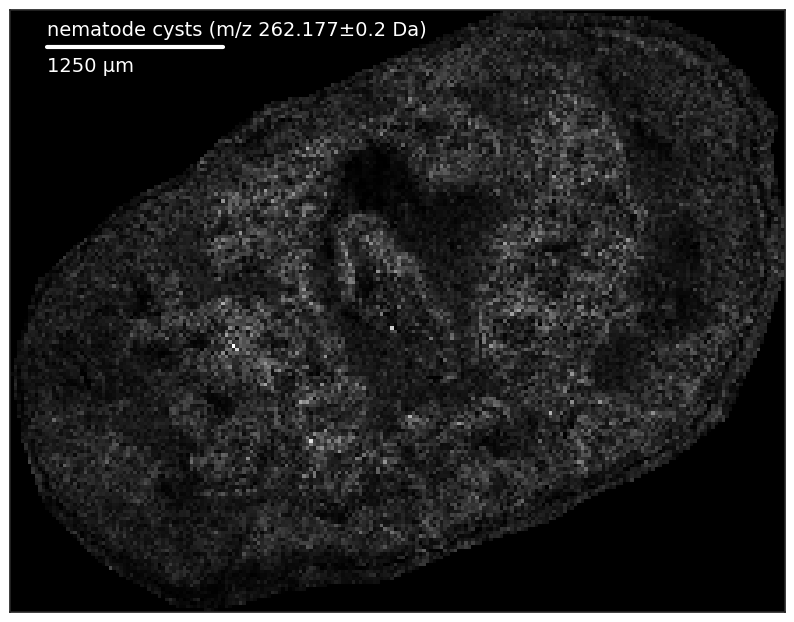

In [3]:
# 1) GetArray(mz, tol) will generate a numpy array, loosing all real world information like the origin, spacing or direction of the image.
# 2) GetImage(mz, tol) will generate a itkImage, that holds those real world information. 
#
# If ion images are produced for further analysis pipelines, it is recommended to use the GetImage method and save the images as .nrrd files [1], using SimpleITK [2].
# E.g.: sitk.WriteImage(I.GetImage(mz,tol), path/to/file.nrrd)
#
# [1] http://teem.sourceforge.net/nrrd/format.html<br/>
# [2] https://simpleitk.org/

# 
I.SetPooling(m2.m2PoolingMean)

MUSC = I.GetArray(1088.868, 0.25)
CONT = I.GetArray(177.919, 0.25)
NEMA = I.GetArray(262.177, 0.25)


showimg(np.squeeze(MUSC), cmap='gray', title='musculature (m/z 1088.868±0.249 Da)')
showimg(np.squeeze(CONT), cmap='gray', title='gut content (m/z 177.919±0.2 Da)')
showimg(np.squeeze(NEMA), cmap='gray', title='nematode cysts (m/z 262.177±0.2 Da)')

Before (3, 171, 220) [Channels, Height, Width]
After (171, 220, 3) [Height, Width, Channels]


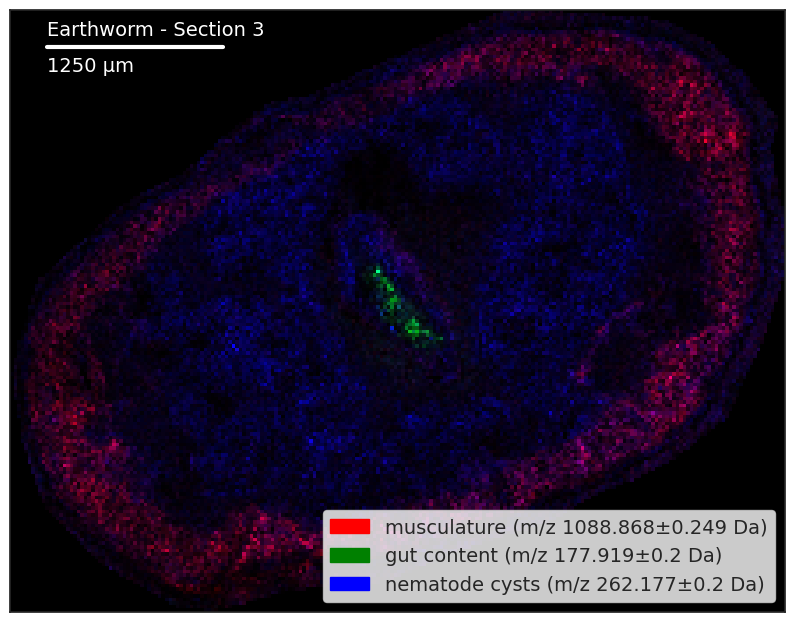

In [4]:
import matplotlib.patches as mpatches
# stack the images
RGB = np.vstack([MUSC,CONT,NEMA])

print('Before', RGB.shape, '[Channels, Height, Width]')

# channelwise rescale intensities to values between 0 and 1
for i in range(3):
    RGB[i] = (RGB[i]-np.min(RGB[i]))/((np.max(RGB[i])-np.min(RGB[i]))) # map to interval [0,1]

# permute dimensions to get a valid image shape
RGB = np.moveaxis(RGB, [0],[2])

print('After', RGB.shape, '[Height, Width, Channels]')
fig, ax = showimg(RGB, title='Earthworm - Section 3')

red_patch = mpatches.Patch(color='red', label='musculature (m/z 1088.868±0.249 Da)')
ax.legend(handles=[red_patch])
green_patch = mpatches.Patch(color='green', label='gut content (m/z 177.919±0.2 Da)')
ax.legend(handles=[red_patch])
blue_patch = mpatches.Patch(color='blue', label='nematode cysts (m/z 262.177±0.2 Da)')
ax.legend(handles=[red_patch])

leg = ax.legend(handles = [red_patch, green_patch, blue_patch],loc='lower right', fontsize=14)

In [6]:
sorted_indices = np.argsort(peak_xs)

sorted_xs = np.array(peak_xs)[sorted_indices]
sorted_idx = np.array(peak_idx)[sorted_indices]
sorted_ys = np.array(peak_ys)[sorted_indices]
sorted_sources = np.array(peaks_source)[sorted_indices]

In [7]:
print(len(peak_xs), len(np.unique(sorted_sources)))


1985541 26744


In [8]:
import importlib
import binning
importlib.reload(binning)

bin_assignments, bin_xs, bin_counts = binning.group_binning(sorted_xs, 
                                                sorted_ys, 
                                                sorted_sources, 
                                                binning.grouper_strict, 
                                                tolerance=0.002)

In [11]:
bin_ids = np.unique(bin_assignments)
filter_mask = [True if len(counts) > 10 else False for counts in bin_counts]
assert(len(bin_ids) == len(filter_mask))

# bin_ids_f = bin_ids[filter_mask]
# print(len(bin_ids), len(bin_ids_f))
# mask = [True if a in bin_ids_f else False for a in bin_assignments]

lookups = np.array([np.sum(sorted_idx[bin_assignments==c])//np.sum(bin_assignments==c) for c in bin_ids])

centroid_data = np.zeros((I.GetNumberOfSpectra(), len(bin_ids)))
# for each spectrum
for i, xs, ys in I.SpectrumIterator():
    
    # mask peaks from this spectrum
    bin_mask = sorted_sources == i
    
    # get all bin ids for this spectrum
    spectrum_bin_ids = bin_assignments[bin_mask]
    # from collections import Counter
    # print(Counter(spectrum_bin_ids))

    # ensure only unique bin ids
    assert(len(spectrum_bin_ids.tolist()) == len(set(spectrum_bin_ids.tolist())))
    centroid_data[i][spectrum_bin_ids] = sorted_ys[bin_mask]

    foreign_bin_ids = np.array([bin_id for bin_id in bin_ids if bin_id not in spectrum_bin_ids])
    centroid_data[i][foreign_bin_ids] = ys[lookups[foreign_bin_ids]]
    print(f"{i}")


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1322
1322


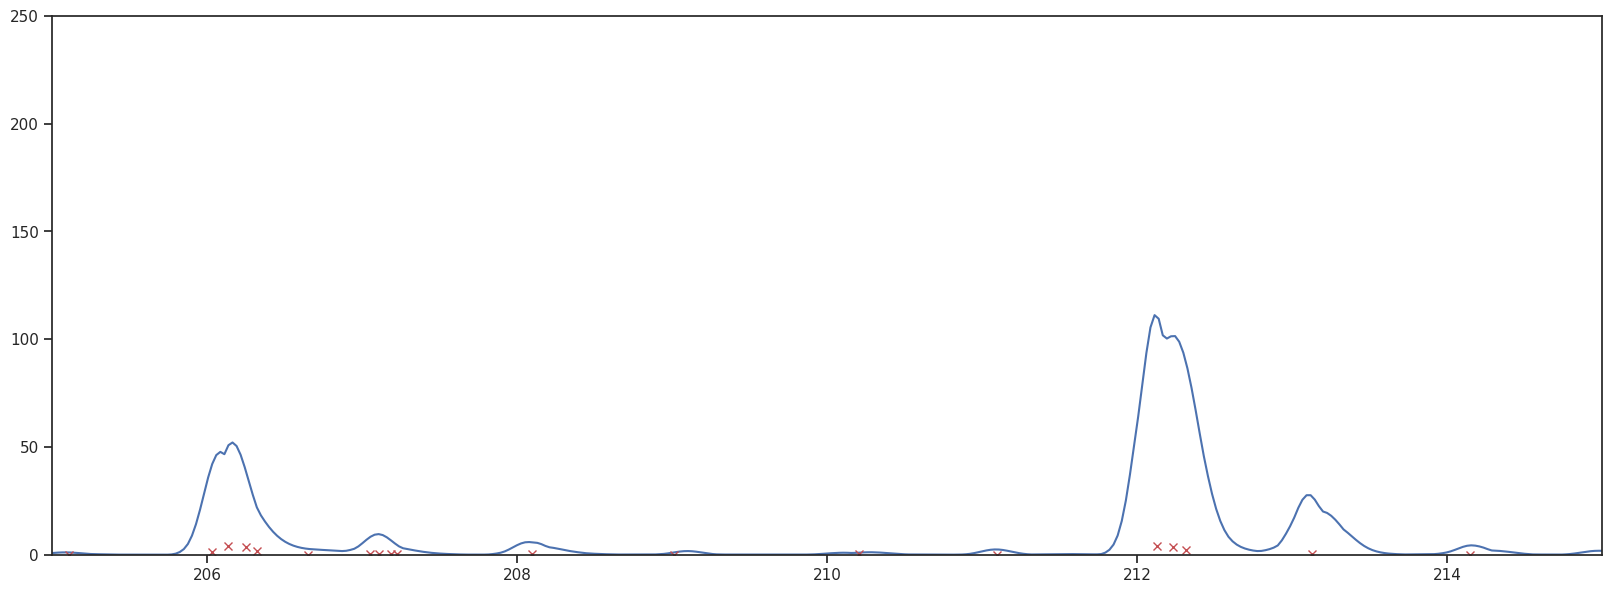

In [26]:
# filter peaks

filter_mask = [True if len(counts) > 10 else False for counts in bin_counts]
ys = I.GetMaxSpectrum()
xs = I.GetXAxis()
print(np.sum(filter_mask))
plt.figure(figsize=(20,7))
plt.plot(xs,ys)
plt.plot(bin_xs[filter_mask], centroid_data[0][filter_mask], 'rx')
plt.xlim([205,215])
plt.ylim([0,250])
print(len(centroid_data[0][filter_mask]))

29693